# Reading and Formatting Data

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
angle = input()
TimeeventsDir = f'./python/MZI/{angle} deg.dat'
# open timeevents
events = []
with open(TimeeventsDir, 'r') as f:
    lines = f.readlines()
    for event in lines:
        # 
        if(event == '\n'):
            continue
        event = event.replace('\n','').split(' ')
        detector = event[0]
        time = int(event[1])
        events.append([detector, time])
# create dataframe
df = pd.DataFrame(events, columns=['Detector', 'Time'])
df['Time'] = pd.to_numeric(df['Time'])
df


,Detector,Time
0,00010,487406
1,00010,496892
2,00010,502136
3,00010,510396
4,00010,526246
...,...,...
2779385,00010,1000614050
2779386,00010,1000617614
2779387,00010,1000622342
2779388,00010,1000649486


In [383]:
import numpy as np
import pandas as pd

def optimize_time_series(df):
    # Convert Time column to numpy array for faster operations
    times = df['Time'].values
    
    # Calculate differences between consecutive times
    time_diffs = np.diff(times)
    
    # Find where resets occur (negative differences larger than a threshold)
    reset_mask = time_diffs < -900e6  # Assuming reset happens around 990e6
    # Create an array of corrections
    corrections = np.zeros_like(times)
    corrections[1:][reset_mask] = times[:-1][reset_mask]
    
    # Apply corrections cumulatively
    final_corrections = np.cumsum(corrections)
    
    # Apply corrections to the original times
    df['Time'] = times + final_corrections
    
    return df

# Apply the function to your DataFrame
df = optimize_time_series(df)


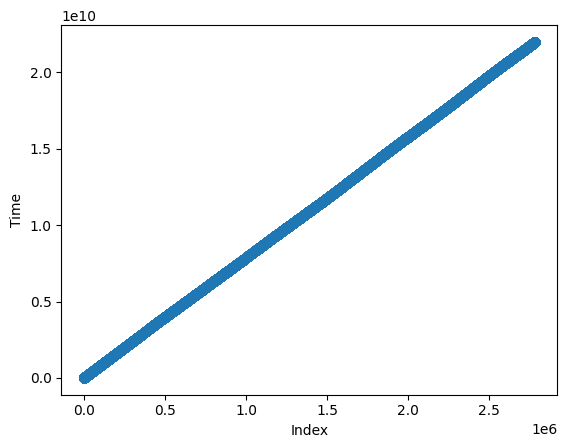

In [384]:
plt.plot(df.index,df['Time'],  'o')
plt.xlabel('Index')
plt.ylabel('Time')
plt.show()

In [385]:
bin_size = 1e6  # This is the value you were using before
# 1ms
# Calculate bin edges
bin_edges = np.arange(df['Time'].min(), df['Time'].max() + bin_size, bin_size)

time_bins = pd.cut(df['Time'], bins=bin_edges)
detector_counts = df.groupby([time_bins, 'Detector']).size().unstack(fill_value=0)

# Rename the index to the middle of each time bin and convert to datetime
detector_counts.index = pd.to_datetime(detector_counts.index.map(lambda x: x.mid), unit='ns')

/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_6326/3848359984.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  detector_counts = df.groupby([time_bins, 'Detector']).size().unstack(fill_value=0)


In [386]:
detector_counts

Detector,00001,00010,00011
Time,,,
1970-01-01 00:00:00.000987406,1,126,0
1970-01-01 00:00:00.001987406,2,141,0
1970-01-01 00:00:00.002987406,1,111,0
1970-01-01 00:00:00.003987406,1,130,0
1970-01-01 00:00:00.004987406,1,130,0
...,...,...,...
1970-01-01 00:00:21.988987406,0,137,0
1970-01-01 00:00:21.989987406,0,130,0
1970-01-01 00:00:21.990987406,2,129,0


# Processing 

In [387]:
detector_counts['Corrected'] = (detector_counts['00010']-detector_counts['00001']).rolling(1500).mean()

# plt.plot(detector_counts.index[10:-20], detector_counts['00010'][10:-20], label='Detector 2 ')
# smooth the data
detector_counts.index = pd.to_datetime(detector_counts.index)

# Calculate seconds passed from the start
detector_counts['Seconds'] = (detector_counts.index - detector_counts.index.min()).total_seconds()




# Identifying Extrema

/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_6326/1679705079.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(detector_counts['Seconds'][peaks], detector_counts['Corrected'][peaks], "x",label = 'peaks')


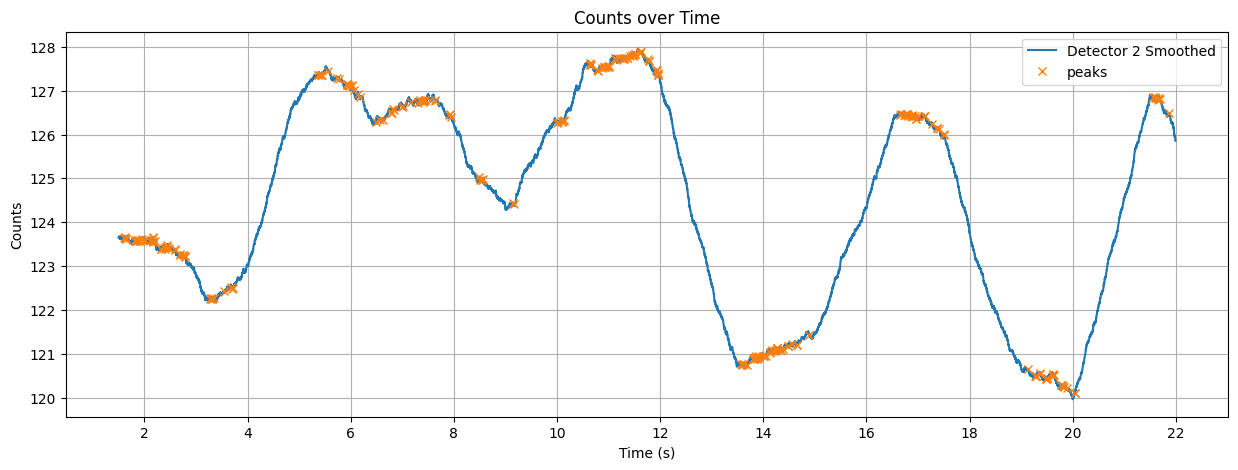

In [388]:
# find peaks in the data after smoothing

from scipy.signal import find_peaks
fig, ax = plt.subplots(figsize=(15, 5))

peaks, _ = find_peaks(detector_counts['Corrected'].rolling(70).mean(), height=0.5)
plt.plot(detector_counts['Seconds'], detector_counts['Corrected'], label='Detector 2 Smoothed')
plt.plot(detector_counts['Seconds'][peaks], detector_counts['Corrected'][peaks], "x",label = 'peaks')
plt.xlabel('Time (s)')
plt.ylabel('Counts')
plt.title('Counts over Time')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.legend()
plt.grid()


/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_6326/3042332274.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.hist(detector_counts['Corrected'][peaks], bins=25)


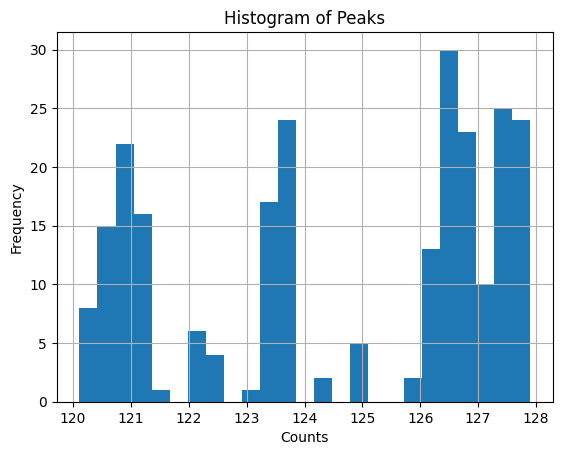

In [389]:
plt.hist(detector_counts['Corrected'][peaks], bins=25)
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.title('Histogram of Peaks')
plt.grid()



In [390]:
blurrinessRange = [128, 131]
# remove all the peaks that are in the blurriness range

peaks = peaks[~detector_counts['Corrected'].iloc[peaks].between(blurrinessRange[0], blurrinessRange[1])]

# make 25 bins out of the peaks, then find the bin with the most items
hist, bin_edges = np.histogram(detector_counts['Corrected'][peaks], bins=25)
max_bin = hist.argmax()
max_bin_edges = bin_edges[max_bin:max_bin+2]
max_bin_edges
predicted_Focus = max_bin_edges.mean()



/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_6326/211295842.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hist, bin_edges = np.histogram(detector_counts['Corrected'][peaks], bins=25)


# Output

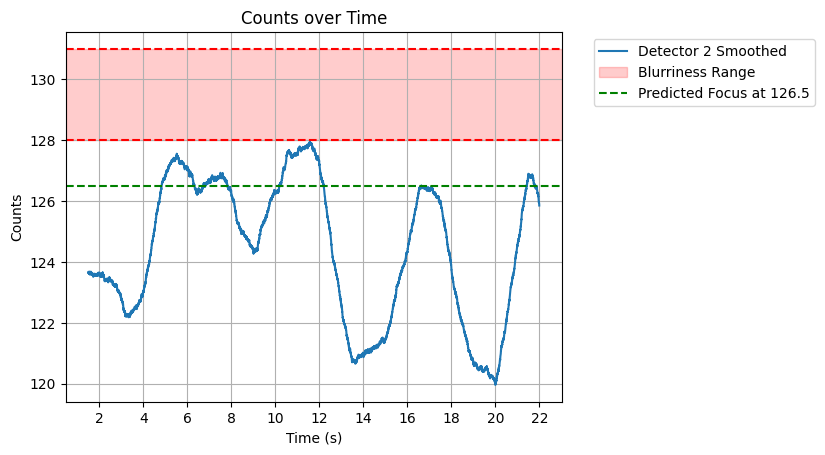

/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_6326/3151615188.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.hist(detector_counts['Corrected'][peaks], bins=25)
/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_6326/3151615188.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xticks(np.arange(min(detector_counts['Corrected'][peaks]), max(detector_counts['Corrected'][peaks]),5 ))


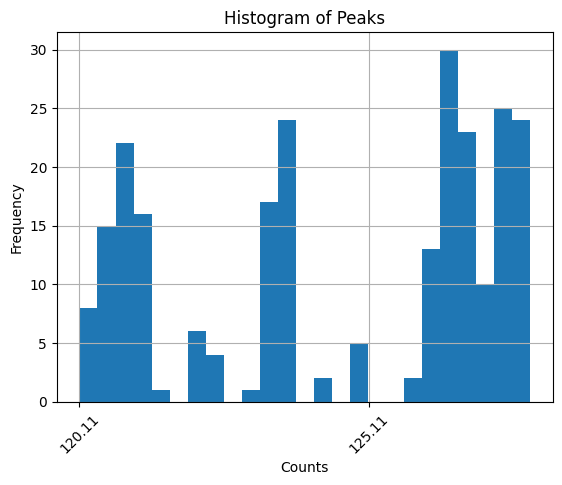

In [391]:

plt.plot(detector_counts['Seconds'], detector_counts['Corrected'], label='Detector 2 Smoothed')
# plt.plot(detector_counts['Seconds'], detector_counts['00001'].rolling(10).mean(), label='Detector 1 Smoothed')

# make the timestamps in seconds for better readability
# make xticks frequency 2
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.grid()

plt.xlabel('Time (s)')
plt.ylabel('Counts')
plt.title('Counts over Time')

plt.axhline(y=blurrinessRange[0], color='r', linestyle='--')
plt.axhline(y=blurrinessRange[1], color='r', linestyle='--')
plt.axhspan(blurrinessRange[0], blurrinessRange[1], color='r', alpha=0.2, label='Blurriness Range')

plt.axhline(y=predicted_Focus, color='g', linestyle='--', label=f'Predicted Focus at {round(predicted_Focus, 1)}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()
plt.hist(detector_counts['Corrected'][peaks], bins=25)
# label all bin increments
plt.xticks(np.arange(min(detector_counts['Corrected'][peaks]), max(detector_counts['Corrected'][peaks]),5 )) 
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Histogram of Peaks')
plt.grid()

/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_6326/4131922808.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax2.hist(detector_counts['Corrected'][peaks], bins=25)
/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_6326/4131922808.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tickSize = (max(detector_counts['Corrected'][peaks])-min(detector_counts['Corrected'][peaks]))/10
/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_6326/4131922808.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

0.7792000000000001


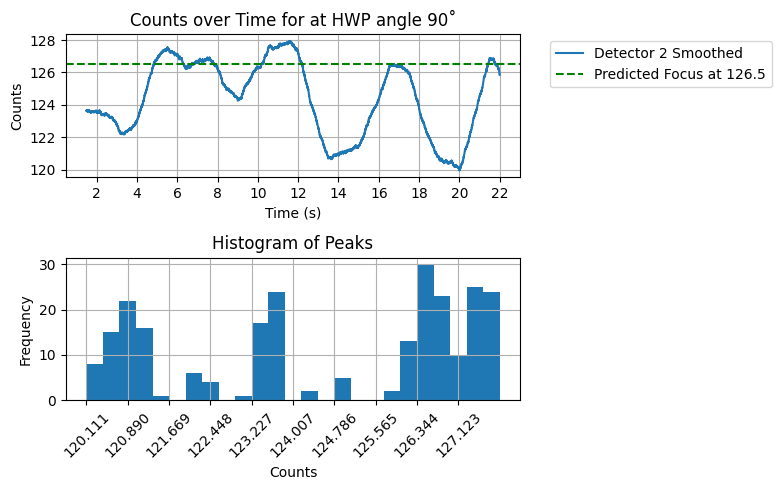

In [392]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming detector_counts, blurrinessRange, predicted_Focus, and peaks are already defined

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))

# Plot 1: Counts over Time
ax1.plot(detector_counts['Seconds'], detector_counts['Corrected'], label='Detector 2 Smoothed')
ax1.xaxis.set_major_locator(plt.MultipleLocator(2))
ax1.grid()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Counts')
ax1.set_title(f'Counts over Time for at HWP angle {angle}˚')
# ax1.axhline(y=blurrinessRange[0], color='r', linestyle='--')
# ax1.axhline(y=blurrinessRange[1], color='r', linestyle='--')
# ax1.axhspan(blurrinessRange[0], blurrinessRange[1], color='r', alpha=0.2, label='Blurriness Range')
ax1.axhline(y=predicted_Focus, color='g', linestyle='--', label=f'Predicted Focus at {round(predicted_Focus, 1)}')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Histogram of Peaks
ax2.hist(detector_counts['Corrected'][peaks], bins=25)
tickSize = (max(detector_counts['Corrected'][peaks])-min(detector_counts['Corrected'][peaks]))/10
print(tickSize)
ax2.set_xticks(np.arange(min(detector_counts['Corrected'][peaks]), max(detector_counts['Corrected'][peaks]), tickSize))
ax2.set_xlabel('Counts')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Peaks')
ax2.grid()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
fig.savefig(f'./MZI Plots/{angle} deg.png')


In [394]:
# combine all the photos in the MSI Plots folder to a gif
import os
import imageio
png_dir = f'./MZI Plots/'
images = []
for file_name in os.listdir(png_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))

imageio.mimsave(f'./MZI Plots/{angle} deg.gif', images, duration=0.5)

/var/folders/ch/4w1x88c120g72bpx7rj47ktw0000gn/T/ipykernel_6326/3245480156.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
